# Compte-rendu des TP d'Optimisation 

 - Mathieu Chalvidal : mathieu.chalvidal@student.ecp.fr
 - Adrien Boilot: adrien.boilot@student.ecp.fr
    


Ce Notebook comporte l'ensemble des résolutions aux problèmes d'optimistion posés dans les séances 1 à 3. Il est proposé avec les résultats de chaque script mais ceux-ci peuvent être relancés pour vérification.

### Importation des librairies utilisées au cours des TP

In [3]:
import os
import time

import matplotlib.pyplot as plt 
import seaborn as sns

import numpy as np
from scipy import optimize
import cvxpy as cp
import networkx as nx
import scipy.spatial as spatial


import warnings
warnings.filterwarnings('ignore')

## Séance 1 - Optimisation continue et optimisation approchée

### 1.1 - Optimisation sans contraintes 

#### Definition des matrices et constantes

In [2]:
#definition des constantes
def definition_constantes():
    B = np.matrix('-1.0; 2.0; -3.5; 1.2; 1.5')
    A = np.matrix([[ 1.0, -1.0, 2.0, -0.9, 2.1],
                   [ 1.25, 2.0, 0.5, 1.2, -0.5],
                   [ -3.0, 2.3, 0.5, 1.3, -2.5],
                   [ -2.2, 2.3, 1.5, 0.5, 1.45],
                   [ -1.2, 3.0, -0.5, 0.75, -1.5]])
    
    S = A*np.transpose(A)
    return A, B, S

def f1(U,B,S):
    n=U.shape[0]
    U=np.matrix(U)
    U.shape=(n,1)
    fU = np.transpose(U) * S * U - np.transpose(B) * U;
    return float(fU)

def f2(U,S):
    n=U.shape[0]
    U=np.matrix(U)
    U.shape=(n,1)
    fU = np.transpose(U) * S * U + np.transpose(U) * np.exp(U);
    return float(fU)

def df1(U,B,S):
    n=U.shape[0]
    U=np.matrix(U)
    U.shape=(n,1)
    dfU = 2 * S * U - B
    dfU = np.array(dfU)
    dfU.shape=(n,)
    return dfU

def gradient_rho_constant(fun, fun_der, U0, rho, tol, args):

    itermax=10000  #nb d'itérations
    xn=U0
    f=fun(xn,*args) #initialisation
    it=0   #compteur
    loss_compt=0
    converged = False;
    
    while (~converged & (it < itermax)):
        it=it+1
        dfx=fun_der(xn,*args)       #valeur courante
        xnp1=xn-rho*dfx             #nouveau point de la fonction
        fnp1=fun(xnp1,*args)
        if abs(fnp1-f)<tol:
            converged = True
        xn=xnp1; f=fnp1; loss_compt+=1;            # nouveau point courant

    GradResults = {
            'initial_x':U0,
            'minimum':xnp1,
            'f_minimum':fnp1,
            'iterations':it,
            'converged':converged,
            'loss_compt':loss_compt
            }
    return GradResults

In [3]:
A,B,S = definition_constantes()
d=B.shape[0]
x0 = np.ones((d,))

#### 1.1.1 Méthode du gradient

rho 0.001   converged True   tps ecoule (gradient_rho_constant): 0.6012270450592041
rho 0.002   converged True   tps ecoule (gradient_rho_constant): 0.3968539237976074
rho 0.003   converged True   tps ecoule (gradient_rho_constant): 0.34827494621276855
rho 0.004   converged True   tps ecoule (gradient_rho_constant): 0.20119810104370117
rho 0.005   converged True   tps ecoule (gradient_rho_constant): 0.22183990478515625
rho 0.006   converged True   tps ecoule (gradient_rho_constant): 0.1565699577331543
rho 0.007   converged True   tps ecoule (gradient_rho_constant): 0.14762115478515625
rho 0.008   converged True   tps ecoule (gradient_rho_constant): 0.15056419372558594
rho 0.009000000000000001   converged True   tps ecoule (gradient_rho_constant): 0.09522104263305664
rho 0.01   converged True   tps ecoule (gradient_rho_constant): 0.09220004081726074
rho 0.011   converged True   tps ecoule (gradient_rho_constant): 0.07721590995788574
rho 0.012   converged True   tps ecoule (gradient_rho_

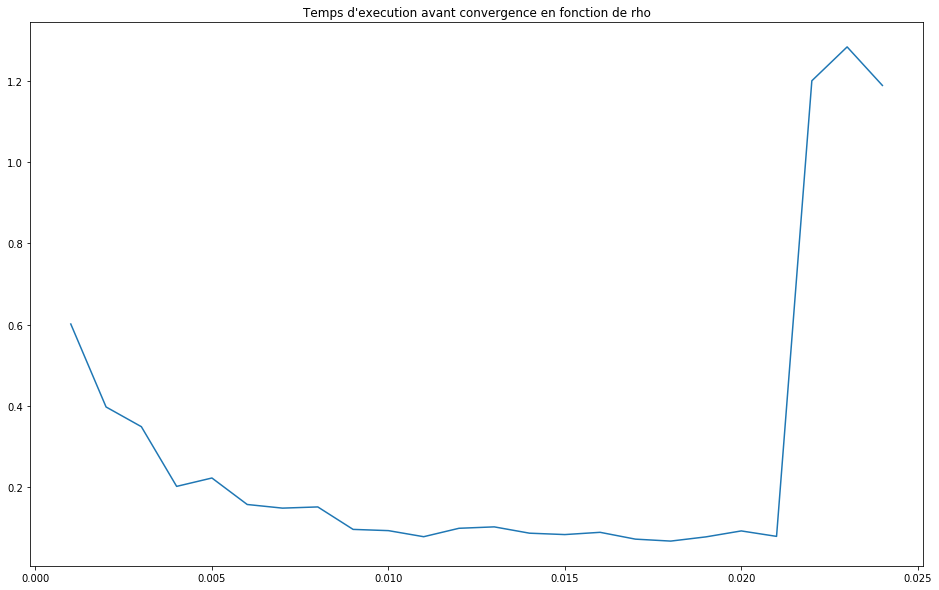

In [4]:
rho_ = [i*0.001 for i in range(1,25)]
results=[]
for rho in rho_:
    debut = time.time()
    GradResults=gradient_rho_constant(f1,df1,x0,rho=rho,tol=1e-6,args=(B,S))
    tps_ecoule = time.time()-debut
    results.append(tps_ecoule)
    print ('rho', rho, '  converged',GradResults['converged'] ,'  tps ecoule (gradient_rho_constant):',tps_ecoule) 

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(rho_,results)
ax.set_title("Temps d'execution avant convergence en fonction de rho")
plt.savefig('testplot.png')

**Interprétation** (voit rapport) : Nous voyons que l'algorithme converge pour les valeurs inférieurs à 0.02 mais ce n'est pas le cas au-delà, ce qui nous conduit à penser que le pas devient trop grand pour atteindre la condition d'arret. Nous remarquons également qu'un pas trop petit entraine un ralentissement de l'algorithme car la convergence est alors faible.

#### b ) Définition de l'algorithme de gradient à pas adaptatif 

In [5]:
def gradient_rho_adaptatif(fun, fun_der, U0, rho, tol,args):

    itermax=10000  #nb d'itérations
    xn=U0          #initialisation
    f=fun(xn,*args) 
    it=0   #compteur
    loss_compt=0
    converged = False;
    
    while (~converged & (it < itermax)):
        it=it+1
        dfx=fun_der(xn,*args)       
        xnp1=xn-rho*dfx             
        fnp1=fun(xnp1,*args)
        if fnp1<f:
            rho=2*rho
            if abs(fnp1-f)<tol:
                converged = True
            xn=xnp1
            f=fnp1
            loss_compt+=1
        else:
            rho=0.5*rho


    GradResults = {
            'initial_x':U0,
            'minimum':xnp1,
            'f_minimum':fnp1,
            'iterations':it,
            'converged':converged,
            'loss_compt':loss_compt
            }
    return GradResults

#### c) Comparaison des performances des méthodes

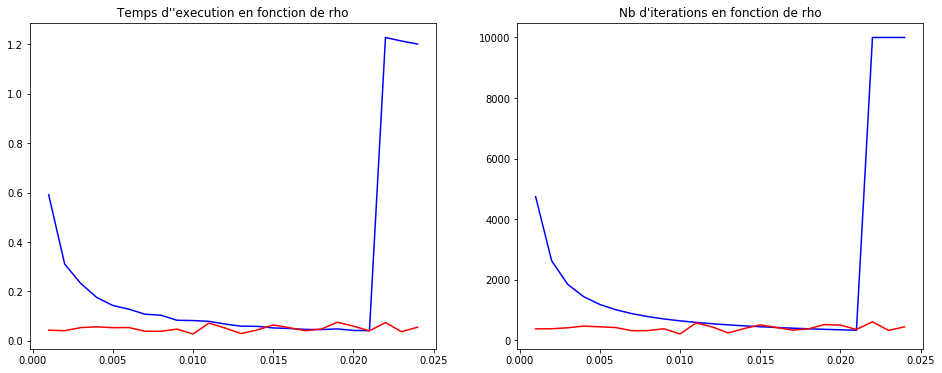

In [8]:
pas_constant=[]
pas_adaptatif=[]

rho_ = [i*0.001 for i in range(1,25)]

for rho in rho_:

    debut = time.time()
    GradResults=gradient_rho_constant(f1,df1,x0,rho=rho,tol=1e-6,args=(B,S))
    tps_ecoule = time.time()-debut
    GradResults['time']=tps_ecoule
    pas_constant.append(GradResults)

    debut = time.time()
    Grad_adapt_Results=gradient_rho_adaptatif(f1,df1,x0,rho=rho,tol=1e-6,args=(B,S))
    tps_ecoule2 = time.time()-debut
    Grad_adapt_Results['time']=tps_ecoule2
    pas_adaptatif.append(Grad_adapt_Results)

iterations=[i['iterations'] for i in pas_constant]
iterations_adaptatif=[i['iterations'] for i in pas_adaptatif]

time_constant=[i['time'] for i in pas_constant]
time_adaptatif=[i['time'] for i in pas_adaptatif]

loss_compt=[i['loss_compt'] for i in pas_constant]
loss_compt_adaptatif=[i['loss_compt'] for i in pas_adaptatif]

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))

ax0.plot(rho_,time_constant,'b')
ax0.plot(rho_,time_adaptatif,'r')
ax0.set_title("Temps d''execution en fonction de rho")

ax1.plot(rho_,iterations,'b')
ax1.plot(rho_,iterations_adaptatif,'r')
ax1.set_title("Nb d'iterations en fonction de rho")

plt.savefig('comparaison_adaptatif_constant.png')

**Interprétation** (voir rapport) : On observe que la méthode de pas adaptatif (rouge) est beaucoup plus stable en terme de temps et d'itérations que la méthode de pas constant (bleue) puisqu'elle résoud le problème de non convergence pour un pas trop fort (ici >0.02) ou de faible convergence pour un pas trop faible (<0.001)

#### 1.1.2 Utilisation de la Méthode de Quasi-Neton avec l'algorithme BFGS

In [9]:
debut = time.time()
res=optimize.minimize(f1,x0,method='BFGS',tol=1e-6,args=(B,S))
tps_ecoule = time.time()-debut
print(res)
print('temps écoulé' ,tps_ecoule, 'sec')

      fun: -1.836962311965238
 hess_inv: array([[ 0.5004328 , -0.21223272,  0.05691395, -0.28056012,  0.50919827],
       [-0.21223272,  0.22383377,  0.0370393 ,  0.11542843, -0.34043246],
       [ 0.05691395,  0.0370393 ,  0.1247386 , -0.04905887, -0.09108766],
       [-0.28056012,  0.11542843, -0.04905887,  0.20504998, -0.28961765],
       [ 0.50919827, -0.34043246, -0.09108766, -0.28961765,  0.77691404]])
      jac: array([-2.98023224e-08, -8.94069672e-08,  1.49011612e-08, -1.49011612e-08,
        1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 91
      nit: 10
     njev: 13
   status: 0
  success: True
        x: array([-0.69603139,  0.15793134, -0.61407083,  0.49414155, -0.05345803])
temps écoulé 0.0204470157623291 sec


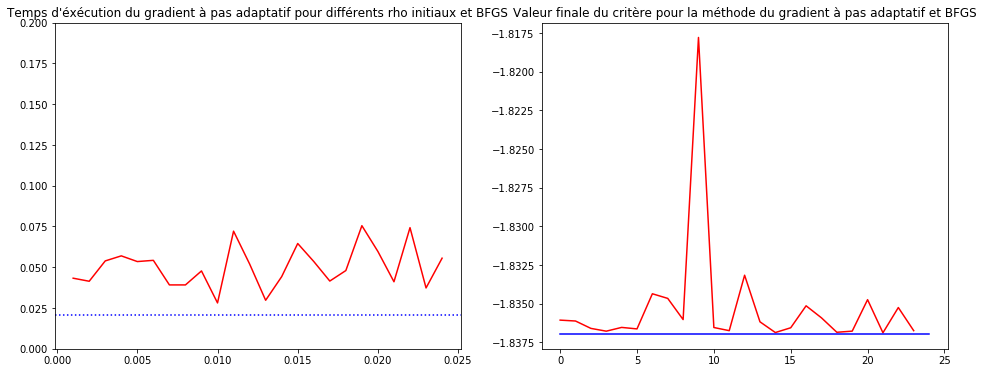

In [12]:
BFGS = [optimize.minimize(f1,x0,method='BFGS',tol=1e-6,args=(B,S)).fun for k in range(25)]

f, (ax0,ax1) = plt.subplots(1, 2, figsize=(16,6))
ax0.plot(rho_,time_adaptatif,'r')
ax0.axhline(y=tps_ecoule, color='b', linestyle=':')
ax0.set_ylim(0, 0.20)
ax0.set_title("Temps d'éxécution du gradient à pas adaptatif pour différents rho initiaux et BFGS")

#plt.savefig('adaptatif_BFGS.png')

f_min_adaptatif=[i['f_minimum'] for i in pas_adaptatif]

ax1.plot(f_min_adaptatif,'r')
ax1.plot(BFGS,'b')
ax1.set_title("Valeur finale du critère pour la méthode du gradient à pas adaptatif et BFGS")

plt.savefig('comparaison_adaptatif_BFGS.png')




## 1.2 Optimisation sous contraintes

### Optimisations à l'aide de routines Python

In [13]:
bounds = ((0, 1),(0, 1),(0, 1),(0, 1),(0, 1))

print("optimisation de f1","\n")
SQP= optimize.minimize(f1,x0,method='SLSQP',bounds=bounds,args=(B,S))
print(SQP,"\n","\n")

print("optimisation de f2","\n")
SQP2= optimize.minimize(f2,x0,method='SLSQP',bounds=bounds,args=(S))
print(SQP2)


optimisation de f1 

     fun: -0.13853161426327318
     jac: array([5.65140143e-01, 1.70478411e-03, 4.86906106e+00, 1.77649595e-03,
       2.70384220e-01])
 message: 'Optimization terminated successfully.'
    nfev: 65
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([4.70812343e-16, 1.26984957e-01, 8.12072123e-16, 1.94536141e-02,
       1.33997327e-16]) 
 

optimisation de f2 

     fun: 1.385691638709516e-15
     jac: array([1.00000018, 1.00000013, 1.00000035, 1.00000023, 1.00000022])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 1.38569164e-15, 0.00000000e+00,
       0.00000000e+00])


### 1.2.2 - Optimisation sous contraintes et pénalisation

#### Definition de la fonction de pénalisation Beta

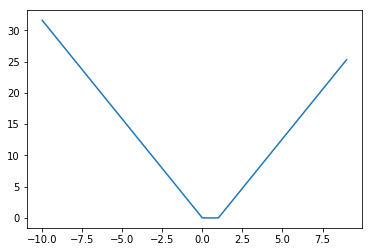

In [14]:
def Beta(U):
    Uad=True
    vec=[]
    for i in U:
        if i<0 or i>1:
            Uad=False
    if Uad==False:
        for i in U:
                vec.append(np.max([0,i-1])+ np.max([0,-i]))
        return np.linalg.norm(vec)
    else:
        return 0

vec = [np.ones(10)*k for k in range(-10,10)]

plt.plot(range(-10,10),[Beta(k) for k in vec])
plt.savefig('Beta_plot')

#### 2 -Algorithme avec penalisation f1penal

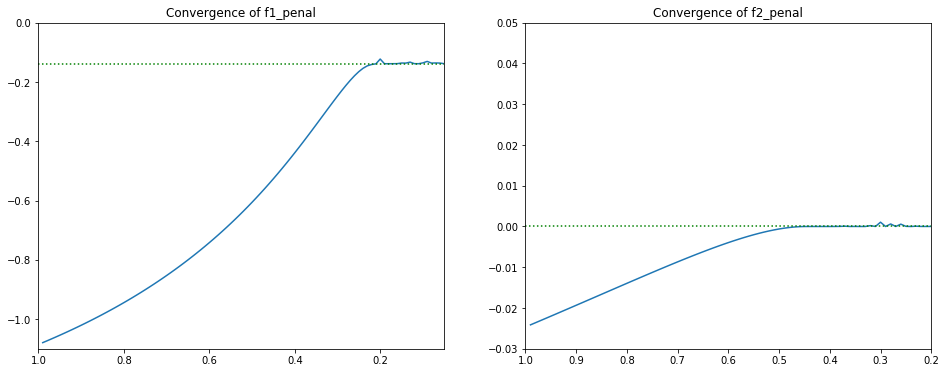

In [15]:
target=SQP.fun
target2=SQP2.fun

def f1_penal(U,B,S,e):
    return f1(U,B,S) + (1/e)*Beta(U)

def f2_penal(U,S,e):
    return f2(U,S) + (1/e)*Beta(U)

#Création de la suite des minimisations de F_1 et F_2

Eps= [0.01*i for i in range(5,100)]
res=[]
iterations=[]
for e in Eps:
    mini=optimize.minimize(f1_penal,x0,method='SLSQP',args=(B,S,e))
    res.append(mini.fun)
    iterations.append(mini.nit)

Eps2= [0.01*i for i in range(20,100)]
res2=[]
iterations2=[]
for e in Eps2:
    mini=optimize.minimize(f2_penal,x0,method='SLSQP',args=(S,e))
    res2.append(mini.fun)
    iterations.append(mini.nit)    
    
#Représentation graphique des résultats
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))

ax0.plot(Eps,res)
ax0.set_title('Convergence of f1_penal')
ax0.axhline(y=target, color='g', linestyle=':')
ax0.set_xlim(1, 0.05)
ax0.set_ylim(-1.1, 0)

ax1.plot(Eps2,res2)
ax1.set_xlim(1, 0.2)
ax1.set_ylim(-0.03, 0.05)
ax1.set_title('Convergence of f2_penal')
ax1.axhline(y=target2, color='g', linestyle=':')

plt.savefig('penal_f1_f2')

### Méthodes duales pour l'optimisation sous contraintes

#### définition du Lagrangien de son gradient en lambda et du vecteur d'initialisation l0

In [16]:
def Lagrangien(U,B,S,l):
    l1=l[0:5]
    l2=l[5:10]
    return f1(U,B,S) + np.dot(l1,U-np.ones(5)) + np.dot(l2,-U)

In [17]:
def Grad_Lagrangien(U,B,S,l):
    vec=np.concatenate((U,-U))
    return l*vec

In [18]:
l0=np.ones(10)

#### définition de l'algorithme d'Uzawa

Minimum de f 
 
 -0.3237945647294948


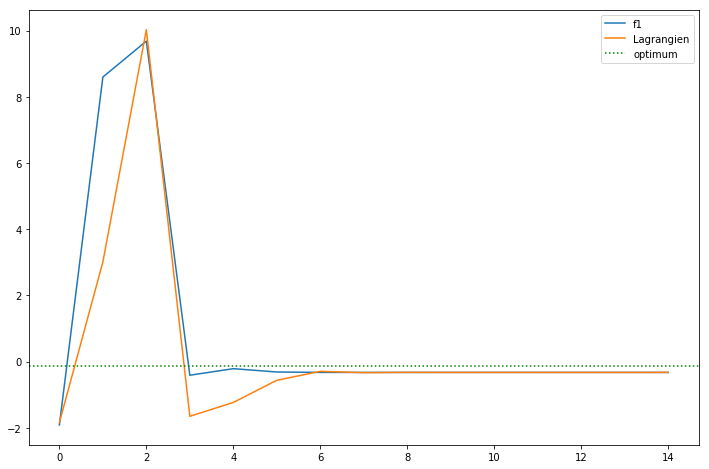

In [19]:
def Uzawa(fun, dfun, U0, l0, args, rho=2, tol=1e-6):
    
    itermax=1000      #nb d'itérations
    xn=U0
    ln=l0
    it=0               #compteur
    history=[]
    f_history=[]
    converged = False;

    while (~converged & (it < itermax)):
        it=it+1
        xnp1=optimize.minimize(fun,xn,method='BFGS',tol=1e-6,args=(B,S,ln)).x
        lnp1= np.maximum(np.zeros(10), ln + rho*dfun(xnp1,B,S,ln))
        if abs(Lagrangien(xnp1,B,S,ln)-Lagrangien(xn,B,S,ln))<tol and np.linalg.norm(xnp1-xn)<tol: 
            converged = True
        xn=xnp1; ln=lnp1; fnp1=Lagrangien(xn,B,S,ln); history.append(xnp1);f_history.append(fnp1)

    GradResults = {
        'initial_x':U0,
        'minimum':xnp1,
        'f_minimum':fnp1,
        'iterations':it,
        'converged':converged,
        'history':history,
        'f_history':f_history
        }
        
    return GradResults

res=Uzawa(Lagrangien, Grad_Lagrangien, x0, l0, args=(B,S))

print("Minimum de f","\n","\n",res['f_minimum'])

f, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(res['f_history'])
ax.plot([f1(k,B,S) for k in res['history']])
ax.axhline(y=target, color='g', linestyle=':')
plt.legend(('f1','Lagrangien','optimum'))
plt.savefig('UzaWa')

### 1-3 Optimisation non convexe - Reucit simulé

#### Définition de f3

In [20]:
def f3(U,B,S):
    return float(f1(U,B,S)+ 10*np.sin(2*f1(U,B,S)))

[array([68.99993278,  6.00008117, 79.0002739 , 77.00023071, 83.0002025 ]), array([37.99998876, 76.00001861, 15.00002663,  2.00001747, 85.0000261 ]), array([77.69442906, 65.337087  ,  1.70805719, 81.76849857, 27.95675861]), array([15.26676119, 14.80180387, 82.32944476, 70.55914646, 96.48459806]), array([36.43761598, 25.65798485, 80.1740475 , 24.15899445, 85.58602031])] 
 
 [array([68.1957502 ,  6.71826046, 80.72305982, 78.55871289, 83.73532469]), array([37.86373782, 76.39445224, 15.1676066 ,  2.20074027, 85.29228397]), array([7.75106764e+01, 6.44174482e+01, 6.59329080e-02, 7.94600327e+01,
       2.65931096e+01]), array([17.04070403, 13.77029868, 78.30919532, 68.18419707, 92.97827979]), array([35.90981027, 23.72223551, 77.78563796, 21.178471  , 83.42196349])]


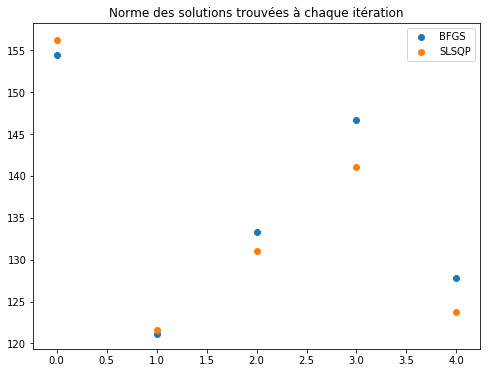

In [21]:
init=[np.random.randint(100, size=5) for i in range(5)]
results_BFGS=[]
results_SLSQP=[]

for i in init:
    results_BFGS.append(optimize.minimize(f3,i,method='BFGS',tol=1e-6,args=(B,S)).x)
    results_SLSQP.append(optimize.minimize(f3,i,method='SLSQP',tol=1e-6,args=(B,S)).x)

print(results_BFGS, '\n','\n', results_SLSQP)

plt.figure(figsize=(8,6))
plt.title("Norme des solutions trouvées à chaque itération")
plt.scatter(range(5),[np.linalg.norm(i) for i in results_BFGS])
plt.scatter(range(5),[np.linalg.norm(i) for i in results_SLSQP])
plt.legend(('BFGS','SLSQP'))

**Interpretation** : On voit qu'une initialisation différente détermine la convergence BFGS et SLSQP vers des minimum locaux différent

L'algorithme converge vers 
 [-1.5  0.5 -0.5  1.  -1. ]


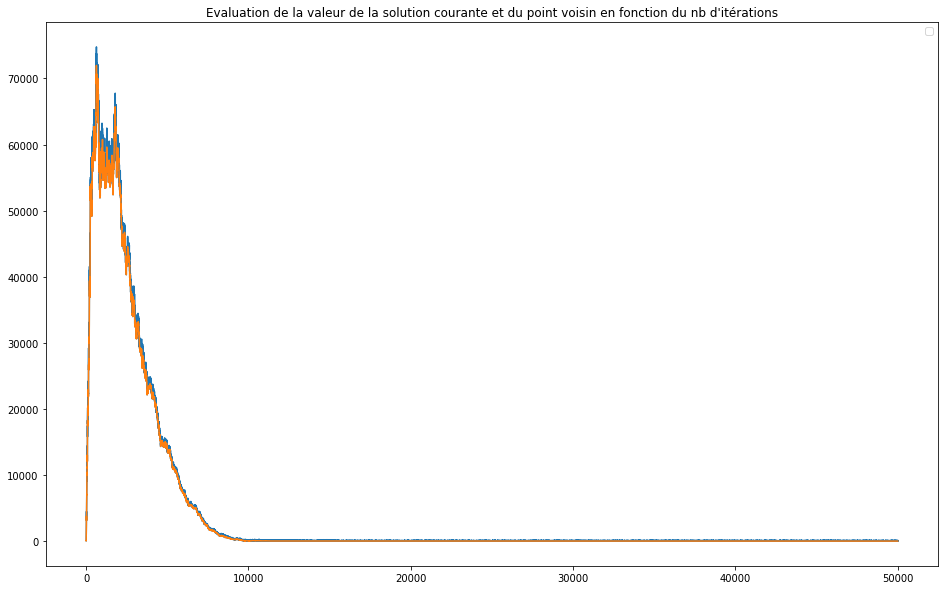

In [22]:
def Recuit_simule(f, U0, t0, palier, args):
    
    itermax=50000  #nb d'itérations
    xn=U0 
    it=0   
    T=t0
    f_history=[]
    current_history=[]
    
    while (it < itermax):
        it=it+1
        fnp1=f(xn,*args)
        if np.mod(it,palier)==0:
            T=0.95*T
        y = xn + np.random.randint(-2,2,len(xn))*0.5
        f_y=f(y,*args)
        
        if fnp1>=f_y:
            xn=y
            current_history.append(f_y)
        elif np.random.binomial(1,(np.exp((fnp1-f_y)/T)))==1:
            xn=y
            current_history.append(f_y)
        else:
            current_history.append(f_y)
        f_history.append(f(xn,*args))
    return xn, f_history ,current_history
    

anneal, f_history, current_history = Recuit_simule(f3, x0, 1000, 100, args=(B,S))
print("L'algorithme converge vers","\n", anneal)

plt.figure(figsize=(16,10))
plt.plot(current_history)
plt.plot(f_history)
plt.title("Evaluation de la valeur de la solution courante et du point voisin en fonction du nb d'itérations")
plt.legend('f_solution courante','f_point du voisinage')
#plt.savefig('Recuit_norm')

In [23]:
Resultats_anneal=[]
for k in range(20):
    x0=x0*k
    Resultats_anneal.append(Recuit_simule(f3, x0, 1000, 100, args=(B,S)))
    print(k,'ème itération')

0 ème itération
1 ème itération
2 ème itération
3 ème itération
4 ème itération
5 ème itération
6 ème itération
7 ème itération
8 ème itération
9 ème itération
10 ème itération
11 ème itération
12 ème itération
13 ème itération
14 ème itération
15 ème itération
16 ème itération
17 ème itération
18 ème itération
19 ème itération


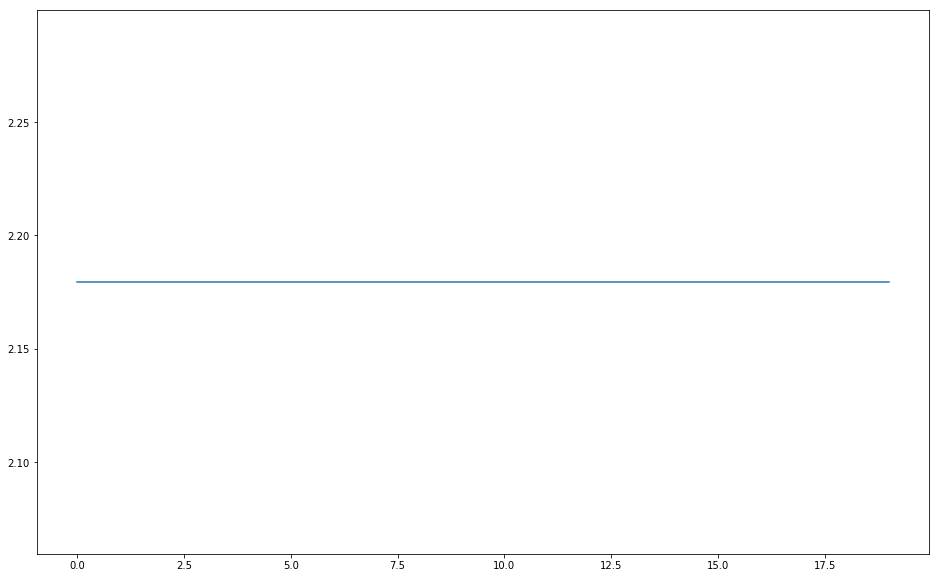

In [24]:
plt.figure(figsize=(16,10))
plt.plot([np.linalg.norm(Resultats_anneal[k][0]) for k in range(20)])
plt.savefig('recuit_stable')

In [59]:
print([Resultats_anneal[k][0] for k in range(20)])

[array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-0.5,  0. , -1. ,  0.5,  0.5]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ]), array([-1.5,  0.5, -0.5,  1. , -1. ])]


### 1.4  - Application Synthèse d'un filtre à réponse impulsionelle finie

In [25]:
def H0(nu):
    if 0 <= nu <= 0.1:
        return 1
    else:
        return 0

def H(h,nu):
    n=len(h)
    H_nu = np.dot(h,[np.cos(2*np.pi*nu*i) for i in range(n)])
    return H_nu

def Critere(h,nu_discret):
    H0_discret=np.array([H0(i) for i in nu_discret])
    H_discret=np.array([H(h,i) for i in nu_discret])
    return np.max(np.abs(H0_discret-H_discret))

h0=np.ones(47)
nu_discret = [0.01*i for i in range(11)] + [0.01*i for i in range(15,51)]

Minimisation = optimize.minimize(Critere,h0,method='SLSQP',tol=1e-6,args=(nu_discret))

In [26]:
Minimisation

     fun: 0.07480190115358024
     jac: array([ 1.        ,  0.42577929, -0.63742399, -0.96858316, -0.18738132,
        0.80901699,  0.87630668, -0.06279052, -0.92977649, -0.72896863,
        0.30901699,  0.9921147 ,  0.53582679, -0.53582679, -0.9921147 ,
       -0.309017  ,  0.72896863,  0.92977649,  0.06279052, -0.87630668,
       -0.809017  ,  0.18738131,  0.96858316,  0.63742399, -0.42577929,
       -1.        , -0.42577929,  0.63742399,  0.96858316,  0.18738131,
       -0.809017  , -0.87630668,  0.06279052,  0.92977649,  0.72896863,
       -0.309017  , -0.9921147 , -0.53582679,  0.53582679,  0.9921147 ,
        0.30901699, -0.72896863, -0.92977649, -0.06279052,  0.87630668,
        0.80901699, -0.18738132])
 message: 'Optimization terminated successfully.'
    nfev: 3199
     nit: 59
    njev: 59
  status: 0
 success: True
       x: array([ 0.27615261,  0.47600944,  0.30417705,  0.10475399, -0.06272904,
       -0.10380033, -0.08817139, -0.01866141,  0.04308577,  0.07131241,
      

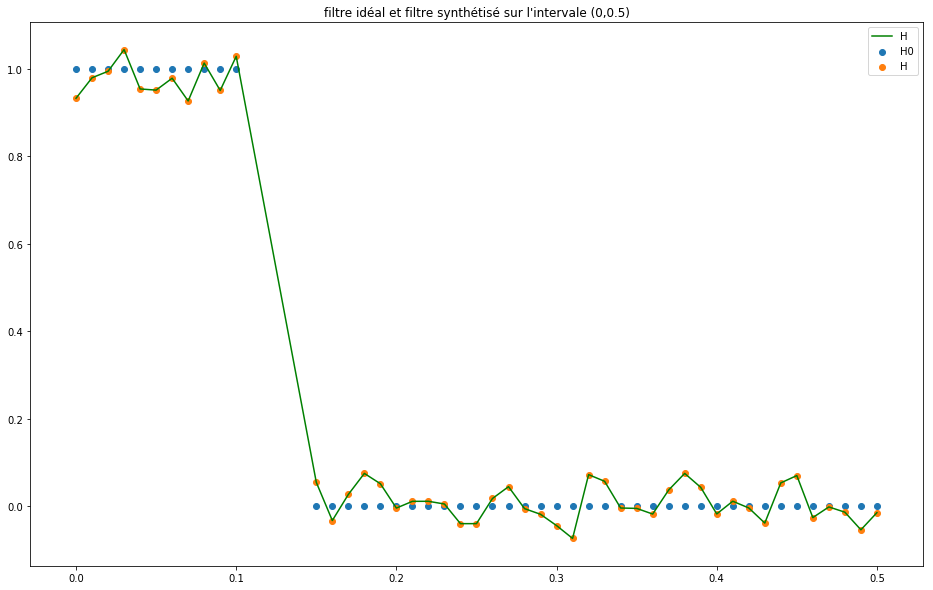

In [27]:
plt.figure(figsize=(16,10))
plt.scatter(nu_discret,[H0(k) for k in nu_discret])
plt.scatter(nu_discret,[H(Minimisation.x,k) for k in nu_discret])
plt.plot(nu_discret,[H(Minimisation.x,k) for k in nu_discret],'g')
plt.title("filtre idéal et filtre synthétisé sur l'intervale (0,0.5)")
plt.legend(('H','H0','H'))
plt.savefig('FRI_scatter')

# Seance 2 et 3 : optimisation discrète et optimisation multi-objectif

#### Question 2 (traitée séparement)

In [14]:
os.chdir('/Users/chalvidalm/Documents/3A OMA/OMA fonda/Optimisation_2017_2018/SÈances_2&3_TP/Les cours/RangerObjets')

Pos_cas = np.loadtxt('PositionCasiers.txt',skiprows=1)
Pos_obj = np.loadtxt('PositionObjets.txt',skiprows=1)

mat=spatial.distance_matrix(Pos_cas,Pos_obj,p=2)
dims=mat.shape

# déclaration de la variable de sélection
selection = cp.Variable((dims[0],dims[0]), boolean=True)

# déclaration des contraintes
constraints = [ cp.sum(selection[i,:]) == 1 for i in range(dims[0]) ]
constraints_col = [ cp.sum(selection[:,j]) == 1 for j in range(dims[1])]

# déclaration du critère
total_distance = cp.sum( mat.flatten() * selection.flatten() )

# déclaration du problème et solution
problem = cp.Problem(cp.Minimize(total_distance), constraints + constraints_col )
problem.solve(solver=cp.ECOS_BB)

if problem.status not in ["infeasible", "unbounded"]:
    # Otherwise, problem.value is inf or -inf, respectively.
    print("Optimal value: %s" % problem.value)
for variable in problem.variables():
    print("Variable %s: value %s" % (variable.name(), variable.value.round(0)**2))

criterium = problem.value
optimum = problem.variables()[0].value.round(0)**2

Optimal value: 15.377627810052134
Variable var0: value [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


#### question 2,3,4,5 (traitée ensemble)

Question N°2
Optimal value: 15.377627810052134
Question N°3
Optimal value: 15.565123298218957
Question N°4
Optimal value: 15.95691618803305
Question N°5
Optimal value: 16.060295790982952


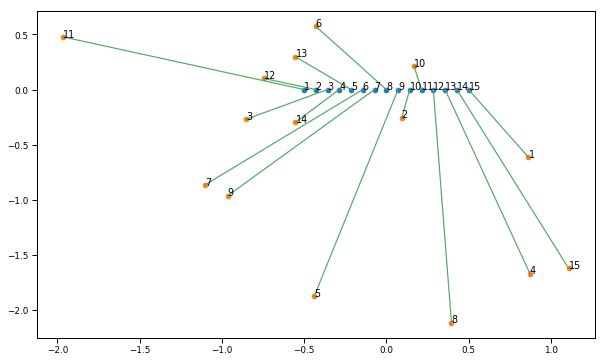

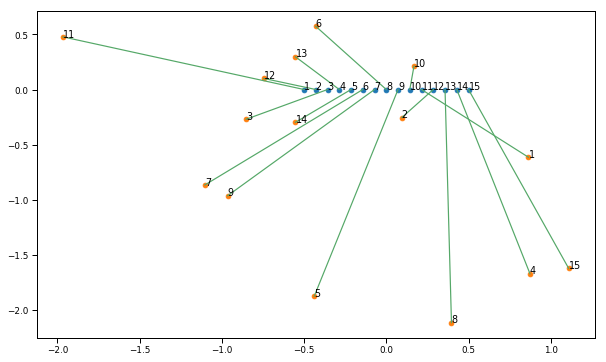

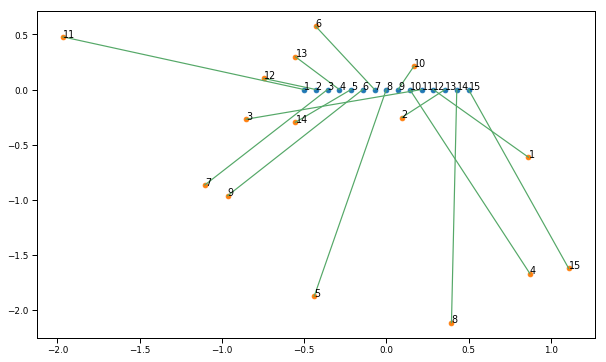

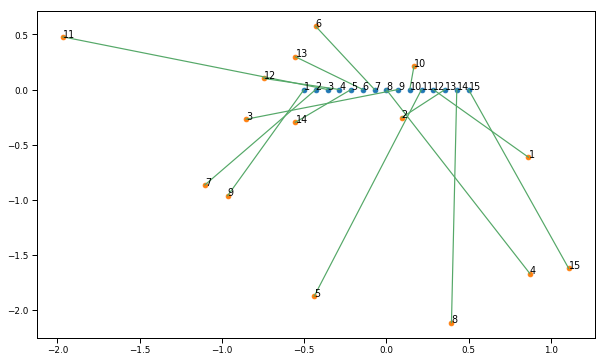

In [16]:
# Déclaration de la variable de selection des combinaisons boite-objet
selection = cp.Variable((dims[0],dims[0]), boolean=True)

#l'ensemble des contraintes proposés dans le problème 
constraints = [ cp.sum(selection[i,:]) == 1 for i in range(dims[0])]
constraints_col = [ cp.sum(selection[:,j]) == 1 for j in range(dims[1])]

constraint_3 = [selection[0,i] == selection[1,i+1] for i in range(dims[0]-1)]

constraint_4=[]
for i in range(dims[0]-1):
    for k in range(i+1,dims[0]):
        constraint_4.append(selection[2,i] + selection[3,k] <= 1)
        
constraint_5 = [selection[6,i] == selection[8,i+1] + selection[8,i-1] for i in range(dims[0]-1)] #+ [selection[0,6] == selection[1,8]] + [selection[dims[0]-1,6] == selection[dims[0]-2,8]]

#Conservation des contraintes dans un dictionnaire
Dic_const={}
Dic_const['2'] = constraints + constraints_col
Dic_const['3'] = Dic_const['2'] + constraint_3 
Dic_const['4'] = Dic_const['3'] + constraint_4
Dic_const['5'] = Dic_const['4'] + constraint_5

# fonction critère a minimiser
total_distance = cp.sum( mat.flatten() * selection.flatten() )


#résolution des problèmes
for k in range(2,6):
    print('Question N°{}'.format(k))
    problem = cp.Problem(cp.Minimize(total_distance), Dic_const[str(k)] )
    problem.solve(solver=cp.ECOS_BB)

    if problem.status not in ["infeasible", "unbounded"]:
        # Otherwise, problem.value is inf or -inf, respectively.
        print("Optimal value: %s" % problem.value)
    #for variable in problem.variables():
        #print("Variable %s: value %s" % (variable.name(), variable.value.round(0)**2))
        
    ### storing optimum for question 6
    criterium = problem.value
    optimum = problem.variables()[0].value.round(0)**2

    plt.figure(figsize=(10,6))
    plt.scatter(Pos_cas.T[0],Pos_cas.T[1])
    for i in range(15):
        plt.annotate(i+1, (Pos_cas.T[0,i],Pos_cas.T[1,i]))
    plt.scatter(Pos_obj.T[0],Pos_obj.T[1])
    for j in range(15):
        plt.annotate(j+1, (Pos_obj.T[0,j],Pos_obj.T[1,j]))
    for i in range(dims[0]):
        for j in range(dims[0]):
            if optimum[i,j]==1:
                plt.plot([Pos_obj.T[0,i],Pos_cas.T[0,j]], [Pos_obj.T[1,i],Pos_cas.T[1,j]], '-g')
    plt.savefig('rangement_{}'.format(k))


In [15]:
selection = cp.Variable((dims[0],dims[0]), boolean=True)

constraints = [ cp.sum(selection[i,:]) == 1 for i in range(dims[0]) ]
constraints_col = [ cp.sum(selection[:,j]) == 1 for j in range(dims[1])]
constraint_6 = [ cp.sum(optimum.flatten()*selection.flatten()) <= dims[0]-2 ]

# Our total utility is the sum of the item utilities
total_distance = cp.sum( mat.flatten() * selection.flatten() )

# We tell cvxpy that we want to minimize total_distance
# subject to weight_constraint list
problem = cp.Problem(cp.Minimize(total_distance), constraints + constraints_col + constraint_3 + constraint_4 + constraint_5 + constraint_6 )

# Solving the problem
problem.solve(solver=cp.ECOS_BB)

if problem.status not in ["infeasible", "unbounded"]:
    # Otherwise, problem.value is inf or -inf, respectively.
    print("Optimal value: %s" % problem.value)
for variable in problem.variables():
    print("Variable %s: value %s" % (variable.name(), variable.value.round(0)**2))
    
optimum_2 = problem.variables()[0].value.round(0)**2
intervertion = optimum==optimum_2

print(intervertion)
changed=[]
for i in range(intervertion.shape[0]):
    for j in range(intervertion.shape[1]):
        if intervertion[i,j]==False and i not in changed:
            changed.append(i)
            print("L'objet {} a été changé de place".format(i))
            
            


NameError: name 'constraint_3' is not defined

#### 2.2 - Communication entre espions (optimisation combinatoire)

Liste des communications directes de l'agent 1 à 15 et probabilité d'interception 
 [([4, 2], 0.006573188), ([4, 1], 0.11174593), ([14, 3], 0.051687792), ([14, 6], 0.0097812709), ([6, 1], 0.098265072), ([3, 5], 0.11556629), ([3, 7], 0.098126964), ([4, 8], 0.063080499), ([4, 9], 0.076838486), ([5, 10], 0.048587778), ([14, 11], 0.027170488), ([1, 12], 0.03947732), ([5, 13], 0.052032753), ([6, 15], 0.03999983)] 
 

Probabilités d'interception d'un message de source l'agent 1 
 0.582935867960408 
 



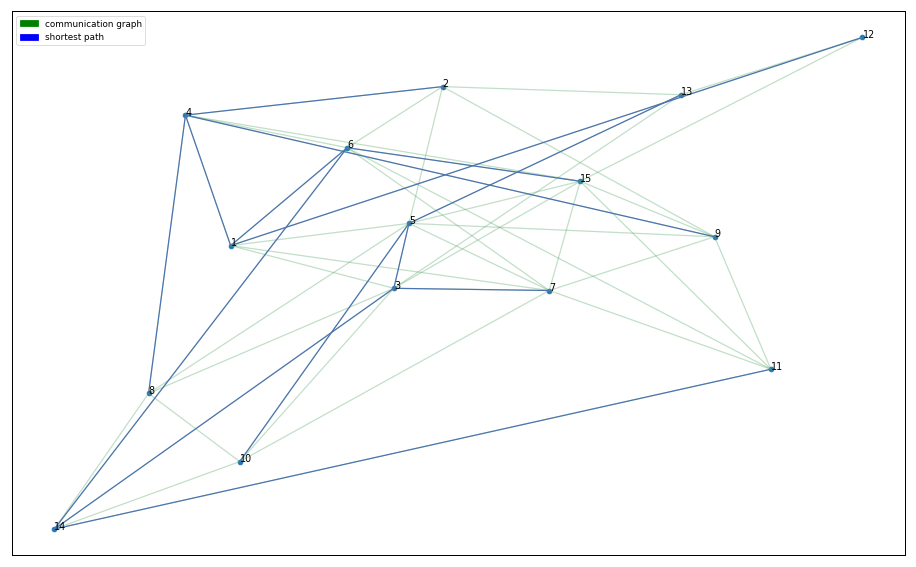

In [139]:
import matplotlib.patches as mpatches

os.chdir('/Users/chalvidalm/Documents/3A OMA/OMA fonda/Optimisation_2017_2018/SÈances_2&3_TP')
Mat_Int = np.loadtxt('ProbaInterception.txt')

#Processing probabilities matrix and create Graph object
Mat_masked = np.ma.masked_invalid(Mat_Int)
Mat_masked_log = -np.log(np.ones(Mat_masked.shape) - Mat_masked)
Graph=nx.from_numpy_matrix(Mat_masked_log)
D = nx.DiGraph(Graph)

# Create force-directed layout for the graph
pos = nx.spring_layout(D)
pos_np = np.array(list(pos.values())).T

# Initialize figure
fig, ax = plt.subplots(1, 1,figsize = (16, 10))

ax.scatter(pos_np[0], pos_np[1])
for i in range(Mat_masked.shape[0]):
    ax.annotate(i+1, (pos_np[0,i], pos_np[1,i]))

#compute shortest path and plot edges
from scipy.sparse.csgraph import shortest_path
G, predecessors = shortest_path(Mat_masked_log, method='BF', return_predecessors=True)  

for i in Graph:
    for j in Graph[i]:
        if Mat_masked[i,j]!=None:
            ax.plot(pos_np[0, [i, j]], pos_np[1, [i, j]], '-g',alpha=.2)
            #ax.plot(pos_np[0, [predecessors[i, j],i]], pos_np[1, [predecessors[i, j],i]], '-r',alpha = .5)
            
ploted=[]
proba_intercept=[]
for i in range(1,15):
    u = predecessors[0,i]
    if [u,i] not in ploted and [i,u] not in ploted:
        ax.plot(pos_np[0, [u,i]], pos_np[1, [u,i]], '-b')
        ploted.append([u,i])
        proba_intercept.append(Mat_masked[u,i])
        while u!=0:
            if [u,predecessors[0,u]] not in ploted and [predecessors[0,u],u] not in ploted:
                ploted.append([u,predecessors[0,u]])
                proba_intercept.append(Mat_masked[u,predecessors[0,u]])
                ax.plot(pos_np[0, [u,predecessors[0,u]]], pos_np[1, [u,predecessors[0,u]]], '-b')
            u=predecessors[0,u]
            
ploted = [list(np.array(u).astype(int)+ np.ones(2).astype(int)) for u in ploted]

green_patch = mpatches.Patch(color='green', label='communication graph')
blue_patch = mpatches.Patch(color='blue', label='shortest path')
plt.legend(handles=[green_patch,blue_patch])


Proba_interception=np.sum([G[i[0]-1,i[1]-1] for i in ploted])
J = 1 - np.exp(-Proba_interception)

print("Liste des communications directes de l'agent 1 à 15 et probabilité d'interception",'\n',list(zip(ploted,proba_intercept)),'\n','\n')

print("Probabilités d'interception d'un message de source l'agent 1",'\n',J,'\n','\n')

_=plt.xticks([])
_=plt.yticks([])
plt.savefig('Graph')

#### dimensionnement d'une poutre

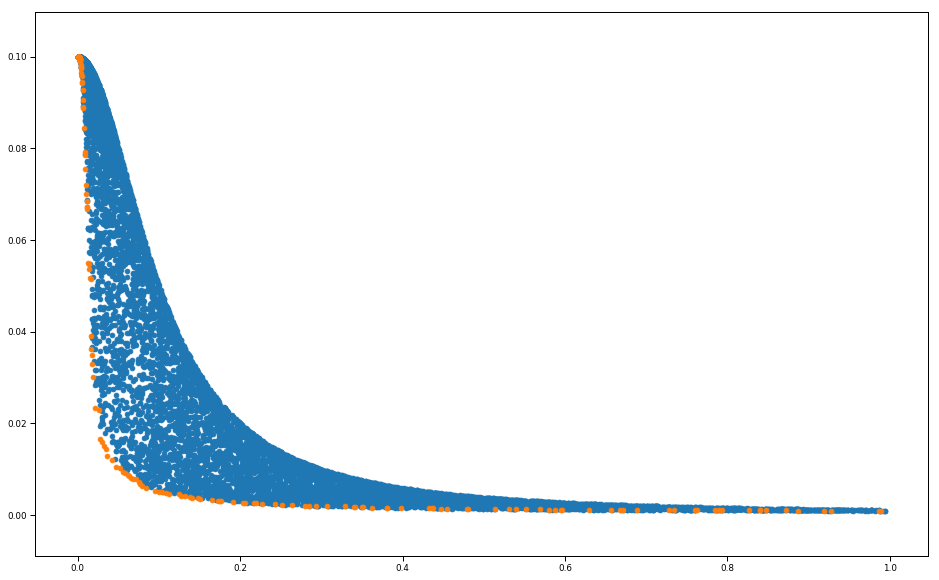

In [4]:
import seaborn as sns
sns.set_context("paper")
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

Poids = lambda a: a[0]**2 - a[1]**2
Def = lambda a: 10**(-3)/(10**(-2) + a[0]**4 - a[1]**4)

Niter = 10000
B=[]
Pds=[]
Defl=[]

A = (1 - 0.02) * np.random.random_sample(Niter) + 0.02
for i in A:
    B.append((i -0.01) * np.random.random_sample())
tirage = list(zip(A,B))

for i in range(len(tirage)):
    Pds.append(Poids(tirage[i]))
    Defl.append(Def(tirage[i]))
    
Pareto=np.array(list(zip(Pds,Defl)))

def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<=c, axis=1)  # Remove dominated points
    return is_efficient

Pareto_efficient=is_pareto_efficient(Pareto)   
Pds_non_opti = np.extract(~Pareto_efficient,Pds)
Defl_non_opti = np.extract(~Pareto_efficient,Defl)
Pds_opti = np.extract(Pareto_efficient,Pds)
Defl_opti = np.extract(Pareto_efficient,Defl)
Pds_opti = np.extract(Pareto_efficient,Pds)
Defl_opti = np.extract(Pareto_efficient,Defl)

fig, ax =plt.subplots(1,1, figsize=(16, 10))
ax.scatter(Pds_non_opti,Defl_non_opti)
ax.scatter(Pds_opti,Defl_opti)

plt.savefig('pareto_glouton')

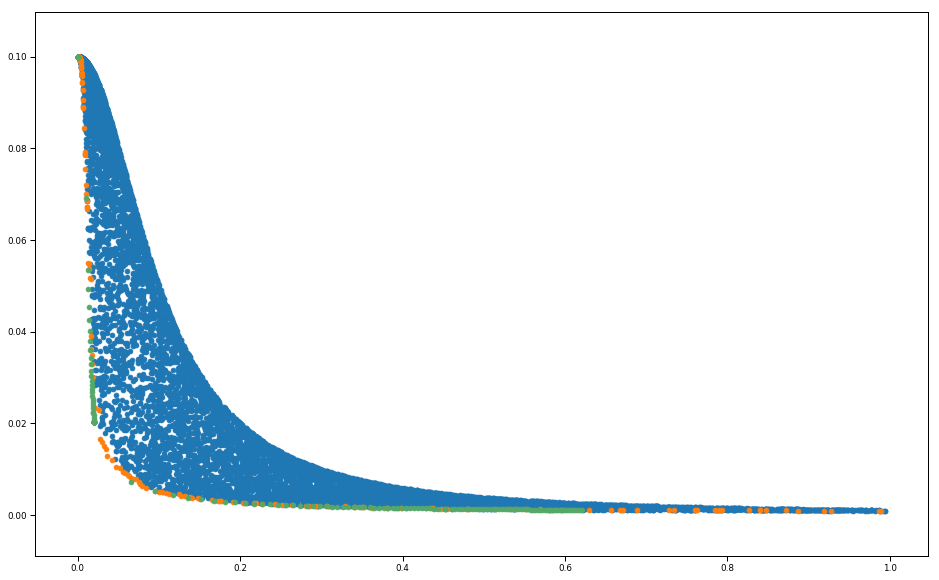

In [11]:
#f = [(lambda v : Poids(v) + k*10*Def(v)) for k in range(1,10)]

cons={'type': 'ineq',
       'fun' : lambda x: - x[1] + x[0] - 0.01}

bounds = ((0.02, 1),(0, None))

alpha=[0.001*k for k in range(1,100)] + [ k for k in range(1,100)]

fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(Pds_non_opti,Defl_non_opti)
ax.scatter(Pds_opti,Defl_opti)
for a in alpha:
    SQP = optimize.minimize((lambda v : Poids(v) + a*10*Def(v)),(0.5,0.48),method='SLSQP',
    constraints=cons,bounds=bounds)
    if SQP.success == True:
        ax.scatter(Poids((SQP.x[0],SQP.x[1])),Def((SQP.x[0],SQP.x[1])), c='g')
plt.savefig('Pareto_sophistiqué_plot')


### 2.4 - Approvisionnement d'un chantier 

In [108]:
os.chdir('/Users/chalvidalm/Documents/3A OMA/OMA fonda/Optimisation_2017_2018/SÈances_2&3_TP')
Donnees = np.loadtxt('DonneesEnginsChantier.txt')
print(Donnees)

[ 36.  61.  84.  87. 121.  88.  66.  69.  71.  78. 116. 149. 130. 158.
 143. 151. 148. 180. 170. 165. 158. 130.  96.  82.  80.  81. 117. 113.
 124. 131. 110. 103. 131. 126. 121. 101. 118.  95.  85.  82.  91.  67.
  75. 118. 145. 138. 150. 147. 120. 102. 146. 130. 166. 160. 167. 153.
 160. 145. 164. 137. 110. 133. 107.  75.  95. 132. 116. 117. 134. 129.
 134. 108. 141. 155. 151. 111. 125. 106.  80.  91.  92.  90.  95. 102.
  87. 106. 100. 112. 149. 171. 157. 173. 137. 134. 141. 165. 149. 173.
 129.]


#### Méthode par résolution d'un plus court chemin

In [ ]:
p_init=800
p_loc=200
p_fin=1200

dmax=int(np.max(Donnees))
Graph=np.zeros((len(Donnees)*int(dmax),len(Donnees)*int(dmax)))

for i in range(1,(len(Donnees)-2)*int(dmax)):
    
    born_inf=((i//dmax)+1)*int(dmax)
    born_sup=((i//dmax)+2)*int(dmax)
    
    for j in range(born_inf+1,born_sup+1):
        
        price_init =p_init*np.max((0,(j%int(dmax))-i)) 
        
        price_loc = p_loc*(j%int(dmax))
        
        price_end = p_fin*np.max((0,i-(j%int(dmax))))
        
        path = price_init + price_loc + price_end
        
        if j%dmax < Donnees[i//dmax]:
            Graph[i,j] = Donnees[i//dmax]
        else:
            Graph[i,j] = path       

In [ ]:
from scipy.sparse.csgraph import shortest_path
best_loc, predecessors = shortest_path(Graph, method='BF', return_predecessors=True)

#### Méthode par programmation dynamique 

In [ ]:
#initlisation
d1=demands.iloc[0]
c1=(d1-0)*800+200*d1
cost=[]
cost.append(c1)
print('La demande pour la semaine 1 est',d1,'machines','et le coût de',c1,'euros')

for i in range(0,98):
    if demands.iloc[i+1]>demands.iloc[i]:
        c=(demands.iloc[i+1]-demands.iloc[i])*800+demands.iloc[i+1]*200
    else:
        if max(demands.iloc[i+1:i+11])-demands.iloc[i]>=0:
            c=(demands.iloc[i])*200 # c'est plus intéressant de garder la machine
        else:
            c=(demands.iloc[i]-max(demands.iloc[i+1:i+11]))*1200+max(demands.iloc[i+1:i+11])*200
            #nouveau nombre de machine à louer à reporter dans df.Demand
            df.Demand_dt.iloc[[i+1]] = max(demands.iloc[i+1:i+11])     
    cost.append(c)
sum(cost)      
print('Le coût minimal est de',sum(cost),'euros')